In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os 
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import radians
from sklearn.metrics.pairwise import haversine_distances
etopo = xr.open_dataset('/export/home/kbalem/Téléchargements/ETOPO_2022_v1_60s_N90W180_geoid.nc')

In [2]:
df = xr.open_dataset('DeepArvorGroundings_all_tids_v3.nc')

In [3]:
gebco_depth = pd.read_csv('extract_gebco_2023_depth_TID_monthly_v3.csv',names=['LON','LAT','DEPTH','TID'],delimiter='\t',header=None)
gebco_depth

,LON,LAT,DEPTH,TID
0,-8.413223,47.342084,-2628.480272,17
1,-8.442629,47.295240,-3109.634941,17
2,-8.450131,47.372846,-2414.657917,17
3,-8.427142,47.330265,-2719.041783,17
4,-8.286585,47.334562,-2540.579260,17
...,...,...,...,...
3903,-26.466395,53.619322,-3649.491323,40
3904,-47.913807,59.349162,-3129.311503,40
3905,-31.463029,50.762062,-3465.877927,40
3906,-16.166423,35.620601,-3110.774339,11


In [4]:
tids = {10:'Singlebeam',11:'Multibeam',17:'Combination',40:'Satellite gravimetry',41:'Interpolation',
        42:'Digital contour from charts',44:'Bathymetric sounding',70:'Pre-generated grid'}

In [5]:
df['eTID'] = xr.DataArray(gebco_depth['TID'].values,dims='N_GRD')
df['eGEBCO'] = xr.DataArray(-1*gebco_depth['DEPTH'].values,dims='N_GRD')
df

<xarray.Dataset>
Dimensions:          (N_GRD: 3908)
Dimensions without coordinates: N_GRD
Data variables: (12/19)
    LATITUDE         (N_GRD) float64 ...
    LONGITUDE        (N_GRD) float64 ...
    PROFILER_TYPE    (N_GRD) float64 ...
    CYCLE_NUMBER     (N_GRD) float64 ...
    WMO              (N_GRD) float64 ...
    GROUNDING_DATE   (N_GRD) datetime64[ns] ...
    ...               ...
    LONGITUDE_C0     (N_GRD) float64 ...
    LONGITUDE_C1     (N_GRD) float64 ...
    LATITUDE_C2      (N_GRD) float64 ...
    LONGITUDE_C2     (N_GRD) float64 ...
    eTID             (N_GRD) int64 17 17 17 17 17 17 40 ... 40 41 40 40 40 11 17
    eGEBCO           (N_GRD) float64 2.628e+03 3.11e+03 ... 3.111e+03 2.198e+03
Attributes:
    title:              Grounding data from Deep Arvor floats
    author:             Kevin Balem
    author_affilation:  IFREMER-LOPS
    author_contact:     kevin.balem@ifremer.fr
    date:               2024-01-15T08:35:25
    Processing 1:       Only grounding occuring during descent to profile are...
    Processing 2:       Corrected positions are calculated from the first GPS...

In [17]:
df.where(df['TID']!=df['eTID'],drop=True)

<xarray.Dataset>
Dimensions:          (N_GRD: 299)
Dimensions without coordinates: N_GRD
Data variables: (12/19)
    LATITUDE         (N_GRD) float64 44.44 46.11 52.76 ... 39.14 39.02 55.5
    LONGITUDE        (N_GRD) float64 -21.52 -21.79 -35.19 ... -25.68 -53.56
    PROFILER_TYPE    (N_GRD) float64 838.0 838.0 838.0 ... 838.0 838.0 838.0
    CYCLE_NUMBER     (N_GRD) float64 87.0 113.0 1.0 33.0 ... 90.0 91.0 120.0
    WMO              (N_GRD) float64 6.902e+06 6.902e+06 ... 6.903e+06 6.903e+06
    GROUNDING_DATE   (N_GRD) datetime64[ns] 2014-11-26T14:39:00 ... 2023-11-2...
    ...               ...
    LONGITUDE_C0     (N_GRD) float64 -21.35 -21.85 -35.28 ... -25.7 -53.65
    LONGITUDE_C1     (N_GRD) float64 -21.53 -21.83 -35.22 ... -25.68 -53.67
    LATITUDE_C2      (N_GRD) float64 44.45 46.1 52.76 ... 39.16 39.02 55.54
    LONGITUDE_C2     (N_GRD) float64 -21.52 -21.82 -35.23 ... -25.68 -53.67
    eTID             (N_GRD) float64 11.0 40.0 44.0 40.0 ... 40.0 40.0 44.0 11.0
    eGEBCO           (N_GRD) float64 3.857e+03 3.759e+03 ... 2.844e+03 2.828e+03
Attributes:
    title:              Grounding data from Deep Arvor floats
    author:             Kevin Balem
    author_affilation:  IFREMER-LOPS
    author_contact:     kevin.balem@ifremer.fr
    date:               2024-01-15T08:35:25
    Processing 1:       Only grounding occuring during descent to profile are...
    Processing 2:       Corrected positions are calculated from the first GPS...

In [11]:
sdf = df.where(df['MIN_DIST_TO_MB']>10,drop=True).dropna('N_GRD')
#sdf = df.dropna('N_GRD')
len(sdf.N_GRD)

1868

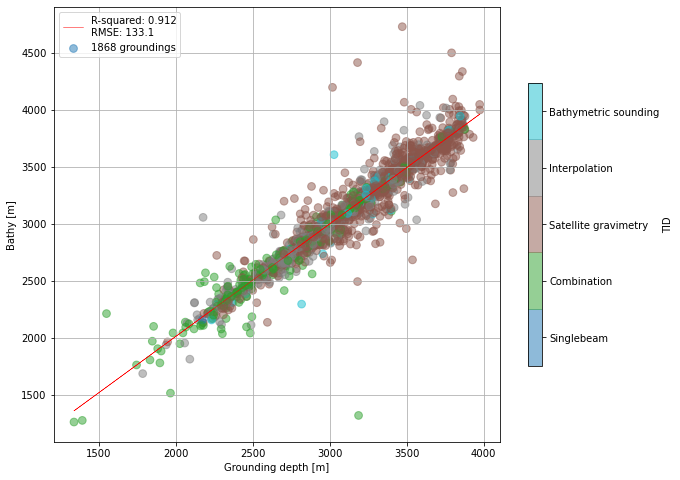

In [12]:
fig,ax = plt.subplots(figsize=(10,8))

xs=sdf['GROUNDING_DEPTH']
ys=sdf['eGEBCO']
cs=sdf['eTID'].values    
res = stats.linregress(xs, ys)

uc = np.unique(cs)
sc = [tids[i] for i in uc]
cc = [np.argwhere(i==uc)[0].flatten() for i in cs] 

a=ax.scatter(xs,ys,s=60,alpha=.5,c=cc,label=f"{len(xs)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=len(uc))
ax.plot(xs, res.intercept + res.slope*xs, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}\nRMSE: {np.sqrt(mean_squared_error(ys, res.intercept + res.slope*xs)):.1f}")    
ax.set_xlabel('Grounding depth [m]')
ax.set_ylabel('Bathy [m]')
ax.legend()

cbar = plt.colorbar(a,ax=ax, shrink=0.65,label='TID')
cbar.set_ticks(np.arange(len(uc))+.5)    
cbar.set_ticklabels(sc)

In [7]:
np.unique(sdf['eTID'].values,return_counts=True)

(array([10, 11, 17, 40, 41, 42, 44]),
 array([   4,  956,  352, 1720,  732,    2,  142]))

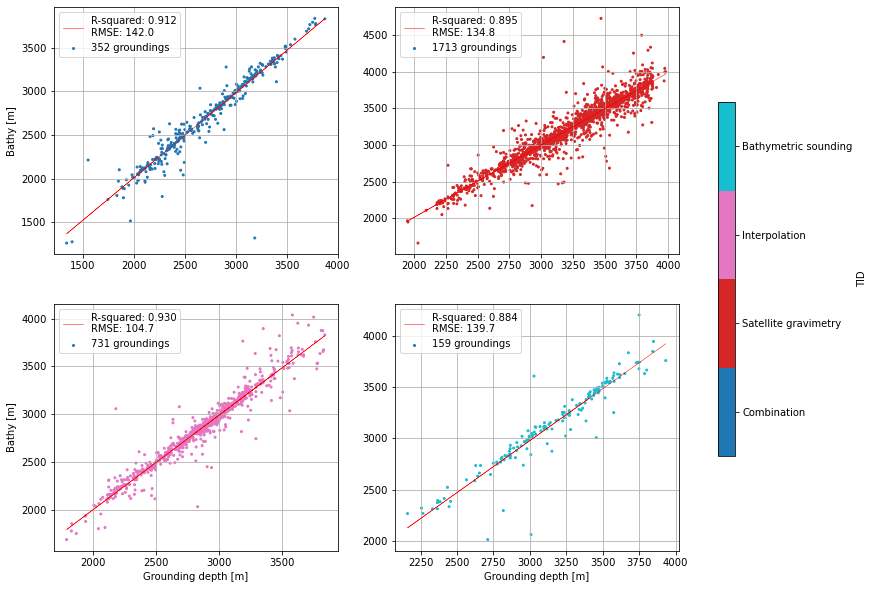

In [8]:
fig,ax = plt.subplots(2,2,figsize=(14,10))

uc = np.array([17,40,41,44]) #np.unique(c)
sc = [tids[i] for i in uc]

k=0
for t in uc:
    lk=int(np.floor(k/2))
    ck=k%2
    
    subgebco = sdf.where(sdf['TID']==t,drop=True)
    xs=subgebco['GROUNDING_DEPTH']
    ys=subgebco['eGEBCO']
    cs=subgebco['TID'].values    
    cc = [np.argwhere(i==uc)[0].flatten() for i in cs] 
    res = stats.linregress(xs, ys)

    a=ax[lk,ck].scatter(xs,ys,s=4,c=cc,label=f"{len(xs)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=len(uc))
    ax[lk,ck].plot(xs, res.intercept + res.slope*xs, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}\nRMSE: {np.sqrt(mean_squared_error(ys, res.intercept + res.slope*xs)):.1f}")    
    ax[lk,ck].legend()
    if(lk==1):
        ax[lk,ck].set_xlabel('Grounding depth [m]')
    if(ck==0):
        ax[lk,ck].set_ylabel('Bathy [m]')
    k+=1
cbar = plt.colorbar(a,ax=ax.ravel().tolist(), shrink=0.65,label='TID')
cbar.set_ticks(np.arange(len(uc))+.5)    
cbar.set_ticklabels(sc)

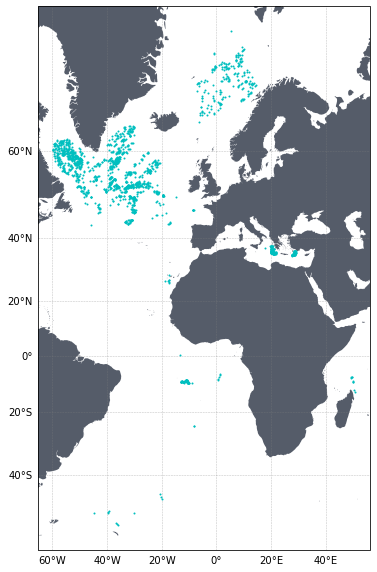

In [53]:
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

ax.plot(sdf['LONGITUDE'],sdf['LATITUDE'],'.c', markersize=4, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#ax.set_extent([-20,0,40,50])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [49]:
res=Geodesic().inverse(points=np.vstack([sdf['LONGITUDE'].values,sdf['LATITUDE'].values]).transpose(),
                       endpoints=np.vstack([sdf['LONGITUDE_C2'].values,sdf['LATITUDE_C2'].values]).transpose())
res=np.array(res)

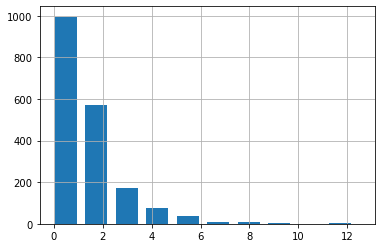

In [52]:
fig, ax = plt.subplots()
ax.hist(res[:,0]/1000.,width=0.9)
ax.grid(True)

Plotting


/opt/anaconda3/envs/OceanPatterns/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


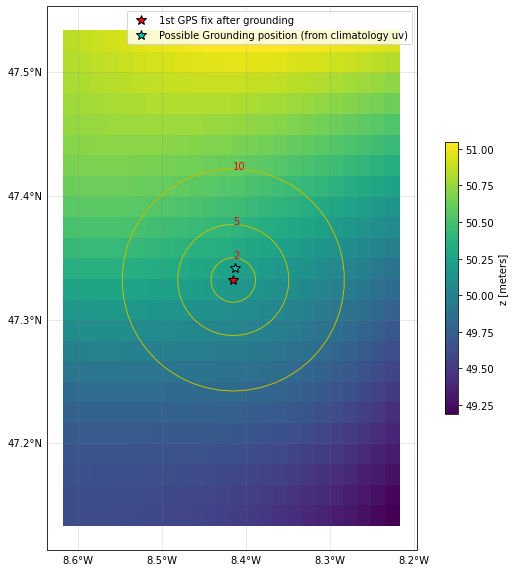

In [41]:
i = 0
du = sdf.isel(N_GRD=i)

print("Plotting")
bathy = etopo
#bathy = gebco
bdim={'x':'lon','y':'lat','z':'z'}
#bdim={'x':'lon','y':'lat','z':'elevation'}
rsize=.2

fig=plt.figure(figsize=(10,10),tight_layout=True)
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

bathy.where((bathy[bdim['x']]>du['LONGITUDE'].values-rsize)&(bathy[bdim['x']]<du['LONGITUDE'].values+rsize)&(bathy[bdim['y']]>du['LATITUDE'].values-rsize)&(bathy[bdim['y']]<du['LATITUDE'].values+rsize),
            drop=True)[bdim['z']].plot(cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())
#bathy.where((bathy[bdim['x']]>du['LONGITUDE'].values-rsize)&(bathy[bdim['x']]<du['LONGITUDE'].values+rsize)&(bathy[bdim['y']]>du['LATITUDE'].values-rsize)&(bathy[bdim['y']]<du['LATITUDE'].values+rsize),
#            drop=True)[bdim['z']].plot.contour(x=bdim['x'],y=bdim['y'],levels=np.arange(-du['GROUNDING_DEPTH']-5,-du['GROUNDING_DEPTH']+5),colors='y',ax=ax, transform=ccrs.PlateCarree())

ax.plot(du['LONGITUDE'],du['LATITUDE'],'*r', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='1st GPS fix after grounding')
#ax.plot(du['LONGITUDE_C0'],du['LATITUDE_C0'],'*c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=11,label='Possible Grounding position (from daily uv)')
ax.plot(du['LONGITUDE_C2'],du['LATITUDE_C2'],'*c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=11,label='Possible Grounding position (from climatology uv)')
plt.legend()

rads = [2,5,10]
for r in rads:
    PTS=np.array(Geodesic().circle(lon=du['LONGITUDE'].values,lat=du['LATITUDE'].values,radius=r*1000,n_samples=50))
    ax.plot(PTS[:,0],PTS[:,1],'y-',linewidth=1, transform=ccrs.PlateCarree())
    ax.text(PTS[0,0],PTS[0,1],str(r),color='r',transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [178]:
sdf_clean.isel(N_GRD=0)

<xarray.Dataset>
Dimensions:          ()
Data variables: (12/15)
    LATITUDE         float64 47.33
    LONGITUDE        float64 -8.415
    PROFILER_TYPE    float64 838.0
    CYCLE_NUMBER     float64 81.0
    WMO              float64 6.902e+06
    GROUNDING_DATE   datetime64[ns] 2014-07-21T15:52:00
    ...               ...
    tid              float64 17.0
    GEBCO_DEPTH      float64 -2.679e+03
    LATITUDE_C0      float64 47.33
    LATITUDE_C1      float64 47.34
    LONGITUDE_C0     float64 -8.411
    LONGITUDE_C1     float64 -8.418

In [18]:
modele = xr.open_dataset('/home/ref-argo/gdac/latest_data/D20231016_prof_0.nc')

In [19]:
list(sdf_clean.variables)

['LATITUDE',
 'LONGITUDE',
 'PROFILER_TYPE',
 'CYCLE_NUMBER',
 'WMO',
 'GROUNDING_DATE',
 'GROUNDING_DEPTH',
 'PROFILE_DATE',
 'mindist',
 'tid',
 'GEBCO_DEPTH',
 'LATITUDE_C0',
 'LATITUDE_C1',
 'LONGITUDE_C0',
 'LONGITUDE_C1']

In [20]:
sdf_clean['LATITUDE'].attrs = modele['LATITUDE'].attrs
sdf_clean['LATITUDE'].attrs['long_name'] = 'Latitude of the first GPS fix following the grounding'
sdf_clean['LONGITUDE'].attrs = modele['LONGITUDE'].attrs
sdf_clean['LONGITUDE'].attrs['long_name'] = 'Longitude of the first GPS fix following the grounding'

sdf_clean['LATITUDE_C0'].attrs = modele['LATITUDE'].attrs
sdf_clean['LATITUDE_C0'].attrs['long_name'] = 'Corrected latitude from Glorys daily velocities'
sdf_clean['LONGITUDE_C0'].attrs = modele['LONGITUDE'].attrs
sdf_clean['LONGITUDE_C0'].attrs['long_name'] = 'Corrected longitude from Glorys daily velocities'

sdf_clean['LATITUDE_C1'].attrs = modele['LATITUDE'].attrs
sdf_clean['LATITUDE_C1'].attrs['long_name'] = 'Corrected latitude from Glorys monthly climatology velocities'
sdf_clean['LONGITUDE_C1'].attrs = modele['LONGITUDE'].attrs
sdf_clean['LONGITUDE_C1'].attrs['long_name'] = 'Corrected longitude from Glorys monthly climatology velocities'

In [21]:
sdf_clean['PROFILER_TYPE'].attrs = modele['WMO_INST_TYPE'].attrs
sdf_clean['CYCLE_NUMBER'].attrs = modele['CYCLE_NUMBER'].attrs
sdf_clean['WMO'].attrs = modele['PLATFORM_NUMBER'].attrs
sdf_clean['GROUNDING_DEPTH'].attrs = {'long_name': 'Grounding depth','units': 'm'}
sdf_clean['GEBCO_DEPTH'].attrs = {'long_name': 'Gebco depth extracted at grounding position','units': 'm'}
sdf_clean['PROFILE_DATE'].attrs = {'long_name': 'Date of the GPS fix following the grounding','standard name': 'time'}
sdf_clean['GROUNDING_DATE'].attrs = {'long_name': 'Date of the grounding','standard name': 'time'}

In [22]:
sdf_clean = sdf_clean.rename({'mindist':'MIN_DIST_TO_MB', 'tid':'TID'})

In [23]:
sdf_clean['TID'].attrs = {'long_name': 'TID value extracted at grounding position'}
sdf_clean['MIN_DIST_TO_MB'].attrs = {'long_name': 'Minimum distance to a multibeam points on TID grid', 'units':'m'}

In [24]:
sdf_clean.attrs = {'title':'Grounding data from Deep Arvor floats',
                   'author':'Kevin Balem',
                   'author_affilation':'IFREMER-LOPS',
                   'author_contact':'kevin.balem@ifremer.fr',
                   'date':np.datetime64('now').astype(str),
                   'Processing 1':'Only grounding occuring during descent to profile are studied here',
                   'Processing 2':'Corrected positions are calculated from the first GPS fix following the grounding, with GLORYS daily product, and monthly climatology',                   
                    }

In [25]:
#remove bad corrected position calculations
sdf_clean = sdf_clean.where(sdf_clean['LONGITUDE_C1']!=0,drop=True)
sdf_clean

<xarray.Dataset>
Dimensions:          (N_GRD: 3908)
Dimensions without coordinates: N_GRD
Data variables: (12/15)
    LATITUDE         (N_GRD) float64 47.33 47.29 47.36 ... 50.77 35.61 72.16
    LONGITUDE        (N_GRD) float64 -8.415 -8.444 -8.452 ... -16.16 -0.4657
    PROFILER_TYPE    (N_GRD) float64 838.0 838.0 838.0 ... 838.0 838.0 838.0
    CYCLE_NUMBER     (N_GRD) float64 81.0 83.0 85.0 86.0 ... 121.0 105.0 123.0
    WMO              (N_GRD) float64 6.902e+06 6.902e+06 ... 6.903e+06 6.904e+06
    GROUNDING_DATE   (N_GRD) datetime64[ns] 2014-07-21T15:52:00 ... 2023-12-0...
    ...               ...
    TID              (N_GRD) float64 17.0 17.0 17.0 17.0 ... 40.0 40.0 11.0 17.0
    GEBCO_DEPTH      (N_GRD) float64 -2.679e+03 -3.183e+03 ... -2.255e+03
    LATITUDE_C0      (N_GRD) float64 47.33 47.27 47.35 ... 50.72 35.6 72.17
    LATITUDE_C1      (N_GRD) float64 47.34 47.29 47.37 ... 50.76 35.61 72.16
    LONGITUDE_C0     (N_GRD) float64 -8.411 -8.465 -8.462 ... -16.14 -0.431
    LONGITUDE_C1     (N_GRD) float64 -8.418 -8.446 -8.458 ... -16.17 -0.4698
Attributes:
    title:              Grounding data from Deep Arvor floats
    author:             Kevin Balem
    author_affilation:  IFREMER-LOPS
    author_contact:     kevin.balem@ifremer.fr
    date:               2024-01-15T08:35:25
    Processing 1:       Only grounding occuring during descent to profile are...
    Processing 2:       Corrected positions are calculated from the first GPS...

In [26]:
sdf_clean.to_netcdf('DeepArvorGroundings_all_tids.nc')